<a href="https://colab.research.google.com/github/afaale/ML/blob/ML/TinyML/Hello_world/TINYML_Hello_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import pandas as pd

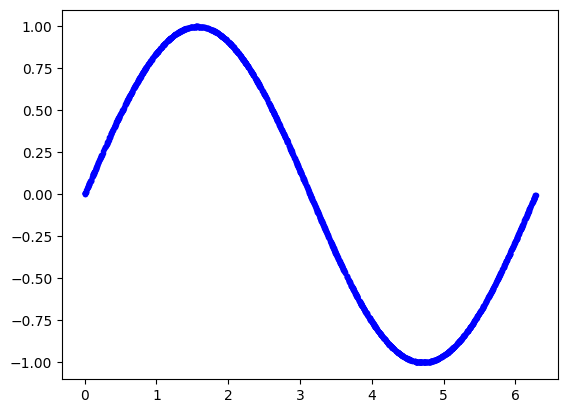

In [3]:
samples = 2000
x_values = np.random.uniform(0, 2 * math.pi, samples)
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')

In [4]:
y_values += 0.1 * np.random.randn(*y_values.shape)

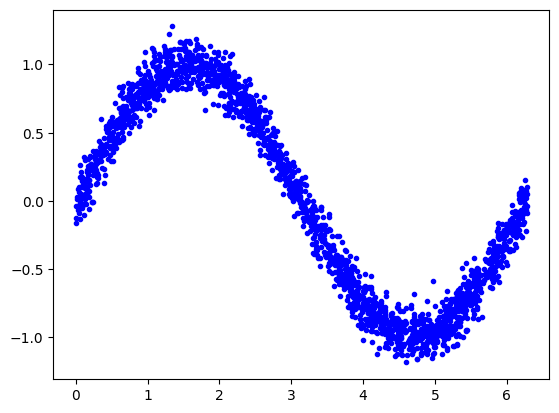

In [6]:
plt.plot(x_values, y_values, 'b.')

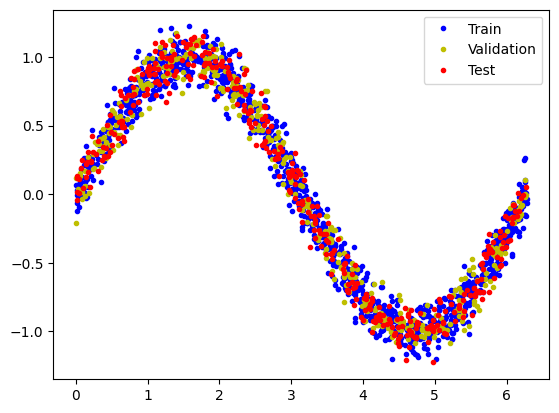

In [5]:
train = int(samples * 0.6)
test = int(samples * 0.2 + train)

X_train, X_test, X_val = np.split(x_values, [train, test])
y_train, y_test, y_val = np.split(y_values, [train, test])

assert (X_train.size + X_test.size + X_val.size) == samples

plt.plot(X_train, y_train, 'b.', label='Train')
plt.plot(X_val, y_val, 'y.', label='Validation')
plt.plot(X_test, y_test, 'r.', label='Test')
plt.legend()

# First model

In [23]:
X_test.shape

(400,)

In [31]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Dense(8, 'relu', input_shape=(1,)))
model1.add(tf.keras.layers.Dense(1))
model1.compile('adam', 'mse', ['mae'])

In [ ]:
history = model1.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_val, y_val))

<Axes: >

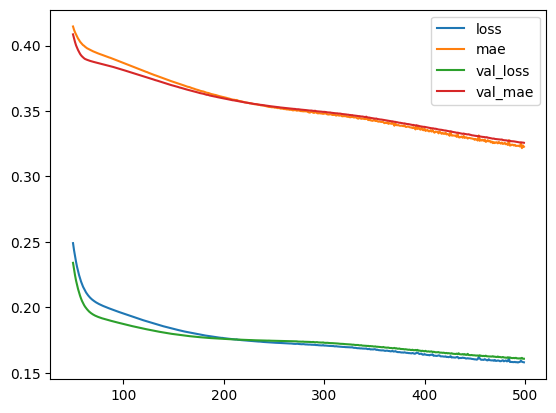

In [33]:
pd.DataFrame(history.history)[50:].plot()

13/13 [==============================] - 0s 2ms/step


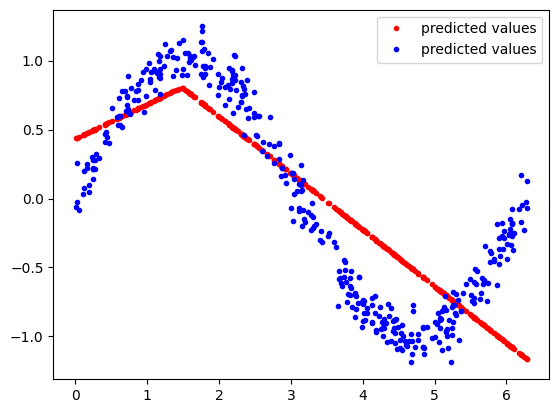

In [34]:
test_loss, test_mae = model1.evaluate(X_test, y_test)

y_test_pred = model1.predict(X_test)

plt.plot(X_test, y_test_pred, 'r.', label='predicted values')
plt.plot(X_test, y_test, 'b.', label='predicted values')
plt.legend()

# Bigger Model

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data = (X_val, y_val))
model.save(MODEL_TF)

<Axes: >

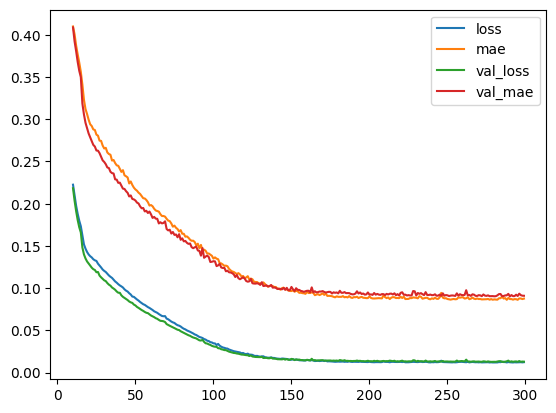

In [11]:
pd.DataFrame(history.history)[10:].plot()

13/13 [==============================] - 0s 2ms/step


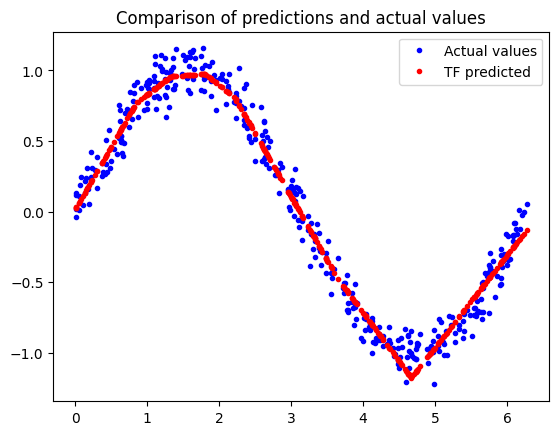

In [12]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(X_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(X_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(X_test, y_test, 'b.', label='Actual values')
plt.plot(X_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

# TensorFlow Lite Model

In [13]:
#convert to TF Lite w/o quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
TFLite_model = converter.convert()

#save to disk
open("sine_model.tflite", "wb").write(TFLite_model)

#convert to TF Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#generator to estimate min/max of all floating point arrays in the model
def representative_dataset_generator():
    for value in X_test:
        yield [np.array(value, dtype=np.float32, ndmin=2)]

converter.representative_dataset = representative_dataset_generator
TFLite_model = converter.convert()
open("sine_model_quantized.tflite", "wb").write(TFLite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


3040

In [15]:
#Instantiate an interpreter for each model
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

#Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

#Get indexes of the input and the output tensors
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

#Create arrays to store the results
sine_model_predictions = []
sine_model_quantized_predictions = []

# Run each model's interpreter for each value and store the results in arrays
for x_value in X_test:
    #Create a 2D tensor wrapping the current x value
    x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)

    #Write the value to the input tensor
    sine_model.set_tensor(sine_model_input_index, x_value_tensor)
    #Run inference
    sine_model.invoke()
    #Read the prediction from the output tensor
    sine_model_predictions.append(
        sine_model.get_tensor(sine_model_output_index)[0])

    # Do the same for the quantized model
    sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
    sine_model_quantized.invoke()
    sine_model_quantized_predictions.append(
        sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])


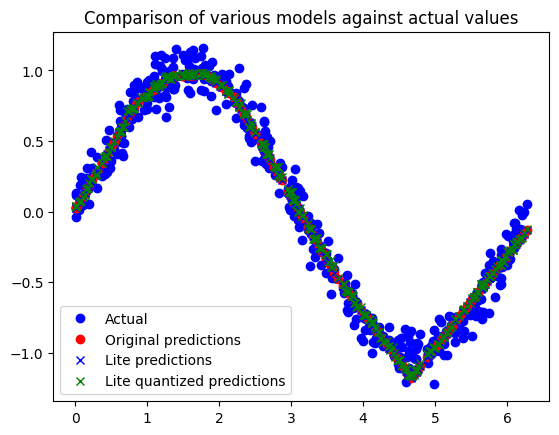

In [19]:
plt.title('Comparison of various models against actual values')
plt.plot(X_test, y_test, 'bo', label='Actual')
plt.plot(X_test, y_test_pred, 'ro', label='Original predictions')
plt.plot(X_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(X_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()

In [25]:
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print(f"Basic model is {basic_model_size} bytes")
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 3192 bytes
Quantized model is 3040 bytes
Difference is 152 bytes


In [26]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc
# Print the source file
!cat sine_model_quantized.cc

unsigned char sine_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0xac, 0x03, 0x00, 0x00,
  0xbc, 0x03, 0x00, 0x00, 0x58, 0x0b, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0xfc, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x0b, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x35, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd6, 0xfc, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0d, 0x00, 0x